In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.cluster import KMeans
import os
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
import joblib

In [4]:
# Load the data
data_path = os.path.join("./", "./data/", "modified_dataset.csv")

try:
    df=pd.read_csv(data_path)
    df.head()
except Exception as e:
    print("File Can't be loaded", e)

In [5]:
df.head()

,source_prefix,dest_prefix,agent,amount,status,label,hour
0,Muffin,Whiskers,A,1000000,fail,0,20
1,Squiggle,Flapjack,A,50000000,success,0,20
2,Flapjack,Squishy,C,2000000,success,0,20
3,Squeegee,Muffin,C,9110000,fail,0,20
4,Whiskers,Snickerdoodle,A,1000000,success,1,20


In [6]:
categorical_columns = ['source_prefix', 'dest_prefix', 'agent', 'status', 'hour']
df_m = pd.get_dummies(df, columns=categorical_columns)
df_m= df_m.astype(int)
df_m.head()

,amount,label,source_prefix_Bacon,source_prefix_Beanie,source_prefix_Biscuit,source_prefix_Boomer,source_prefix_Bubbles,source_prefix_Cheesepuff,source_prefix_Chuckles,source_prefix_Dizzy,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,9110000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1000000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
# Split the data using Stratified Splitting
X = df_m.drop(columns=['label']) 
y = df_m['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# Save train and test data
joblib.dump((X_train, y_train), 'train_data.joblib')
joblib.dump((X_test, y_test), 'test_data.joblib')

['test_data.joblib']

In [9]:
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [10]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [11]:
# 4. Apply KMeans with GridSearchCV for hyperparameter tuning
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200, 300],
    'n_init': [10, 20, 30]
}

In [12]:
# Define KMeans model
kmeans = KMeans()

In [13]:
# Define custom scorer for optimizing precision and recall
def custom_scorer(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (precision + recall) / 2

In [14]:
# Perform GridSearchCV
grid_search = GridSearchCV(kmeans, param_grid, scoring=make_scorer(custom_scorer), cv=5)
grid_search.fit(X_train_scaled)

GridSearchCV(cv=5, estimator=KMeans(),
             param_grid={'init': ['k-means++', 'random'],
                         'max_iter': [100, 200, 300],
                         'n_clusters': [2, 3, 4, 5], 'n_init': [10, 20, 30]},
             scoring=make_scorer(custom_scorer, response_method='predict'))

In [15]:
# Get the best model
best_kmeans = grid_search.best_estimator_

In [17]:
# Make predictions
y_pred = best_kmeans.predict(X_test_scaled)

In [18]:
# Set threshold based on fraud rate of 3.5%
fraud_rate = 0.035
threshold = np.percentile(y_pred, 100 - fraud_rate * 100)

In [19]:
# Convert predictions to binary based on threshold
y_pred_binary = (y_pred >= threshold).astype(int)

In [20]:
# Calculate evaluation metrics
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
cm = confusion_matrix(y_test, y_pred_binary)

In [21]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:")
print(cm)

Precision: 0.021956087824351298
Recall: 0.07462686567164178
F1-Score: 0.03392967304133251
Confusion Matrix:
[[18021  2450]
 [  682    55]]


In [22]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

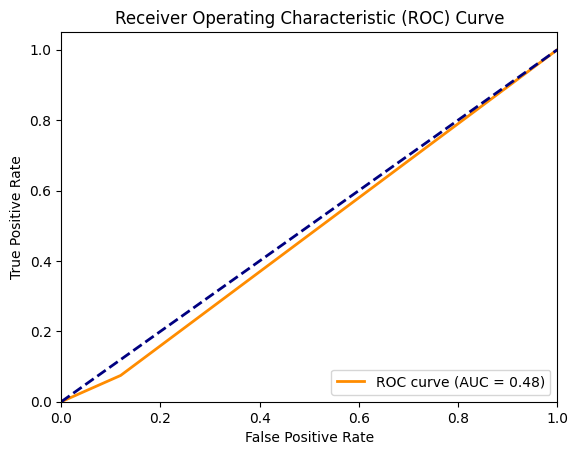

In [23]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### The KMeans clustering model for fraud detection shows the following performance metrics: 
### Precision: 0.0220 (2.20%) This low precision indicates that only 2.20% of the instances predicted as fraud were actually fraudulent. This suggests a high number of false positives.
### Recall: 0.0746 (7.46%) The recall value shows that the model correctly identified 7.46% of all actual fraudulent cases. This low recall indicates that the model missed a significant number of fraudulent transactions.
### F1-Score: 0.0339 (3.39%) The F1-score, which is the harmonic mean of precision and recall, is very low at 3.39%. This indicates poor overall performance of the model in balancing precision and recall.
### Confusion Matrix: The confusion matrix reveals that while the model correctly identified a large number of non-fraudulent transactions (TN), it also misclassified many non-fraudulent transactions as fraudulent (FP). Additionally, it failed to detect a significant number of actual fraudulent transactions (FN).